 <font size="6">  Image Feature Extraction </font> 

---

In this notebook, we will extract cellular features based on the segmentation and on the data after denoise, and normalization with the parameters set from previous preprocessing

## Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from davinci.vectra_tool import *
import imageio
import tifffile
import warnings
warnings.filterwarnings('ignore')
import sys, gc,multiprocessing
from joblib import Parallel, delayed


## Load Files

### Load Image

In [2]:
tiff_images = sorted(glob.glob('../data/tif/*.tif') )
rgb_images = sorted(glob.glob('../data/RGB_2/*.png') )

### Load Mask

In [3]:
rle_images = sorted(glob.glob('../data/segmentation/*.txt') )

### Load sample information

In [4]:
sample_ids = (np.array([x.split('/')[-1].split(' ')[0] for i,x in enumerate(tiff_images)]))
sample_id,count = np.unique(np.array([x.split('/')[-1].split(' ')[0] for i,x in enumerate(tiff_images)]), return_counts=True)
print(sample_id,count)

['Sample1' 'Sample2'] [1 1]


### Load marker information

In [5]:
marker_list =  ['chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan6', 'chan7'] #for real vectra data:  [x.description.split('<Name>')[1].split(' ')[0].split('<')[0].split('+')[0] for x in tifffile.TiffFile(tiff_images[0]).pages[:7] ]

### Confirm the match of name of the image and mask file

In [6]:
unique_id_1 = [(x.split('/')[-1].split(' ')[0] + '-'+x.split('/')[-1].split('[')[-1].split(']')[0]) for x in tiff_images]
unique_id_2 = [(x.split('/')[-1].split(' ')[0] + '-'+x.split('/')[-1].split('[')[-1].split(']')[0]) for x in rle_images]
print('file number',len(unique_id_1),len(unique_id_2))
print('File names match between images and masks: **',unique_id_1==unique_id_2,'**')

file number 2 2
File names match between images and masks: ** True **


### Confirm the match of content of image and mask (optional)

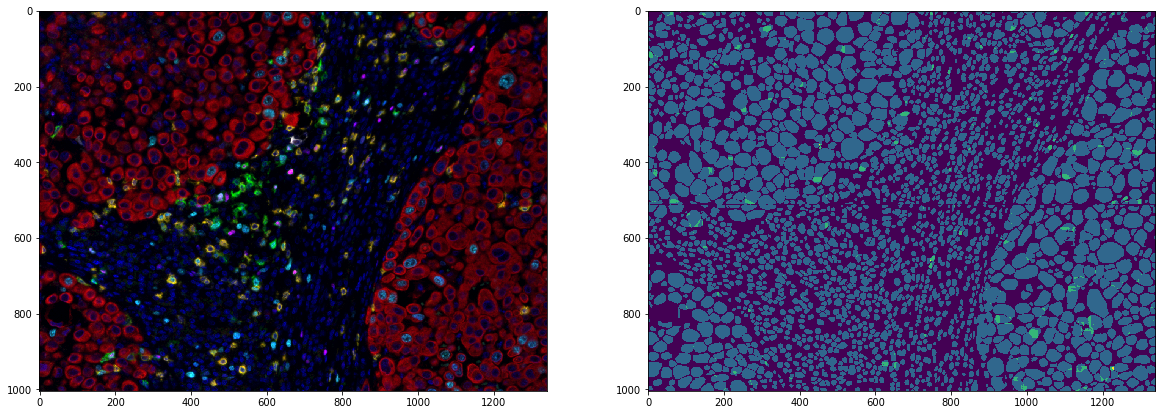

In [7]:
id_image =0
stacked_mask=np.sum(np.array(rle2mask(rle_images[id_image])),axis=0)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(imageio.imread(rgb_images[id_image]))
plt.subplot(1,2,2)
plt.imshow(stacked_mask)

## Generate feature matrix

We will have the following features in the matrix:
['id_image','id_sample','id_cell','area','centroid_x','centroid_y','orientation','eccentricity','minor_axis_length','major_axis_length'] + marker_feature

To remove the batch effect and the noise, we need to do norm and clean. The clean could be done by threshoding on the noise level, whichi was part of pre-processing. As for normalization, we could be norm the image value by sample-global smoothed max value. 

In [8]:
cap_df = pd.read_csv('../parameter/max_cap.csv',index_col=0)
min_df = pd.read_csv('../parameter/threshold.csv',header=None)

In [9]:
num_cores = multiprocessing.cpu_count()-2
num_image = len(rle_images)
results = Parallel(n_jobs=num_cores,verbose=1)(delayed(CM_generator_image)(tiff_images=tiff_images,rle_images=rle_images,marker_list=marker_list,list_sample=sample_ids,unique_sample=sample_id,sample_max_df=cap_df,sample_min_df=min_df,id_image=i) for i in tqdm(range(num_image)))

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of   2 | elapsed:  1.3min finished


In [10]:
df = pd.concat(results,axis=0, ignore_index=True)

In [11]:
df.head()

,id_image,id_sample,id_cell,area,centroid_x,centroid_y,orientation,eccentricity,minor_axis_length,major_axis_length,...,chan3_sum,chan3_area,chan4_sum,chan4_area,chan5_sum,chan5_area,chan6_sum,chan6_area,chan7_sum,chan7_area
0,0,0,0,1210,219.973554,278.774380,0.522728,0.654188,34.164038,45.170671,...,0.0,0,0.0,0,0.0,0,125.333908,608,309.323395,1035
1,0,0,1,955,132.105759,491.805236,-0.947136,0.600777,31.254876,39.097103,...,0.0,0,0.0,0,0.0,0,125.186615,566,226.600449,733
2,0,0,2,1145,48.865502,571.517904,1.327232,0.071598,38.324341,38.422952,...,0.0,0,0.0,0,0.0,0,123.057541,732,278.526947,876
3,0,0,3,1056,12.583333,547.391098,-1.338015,0.727706,31.061114,45.285930,...,0.0,0,0.0,0,0.0,0,153.976151,747,258.177643,832
4,0,0,4,1357,394.900516,250.998526,1.332521,0.572905,37.762277,46.072811,...,0.0,0,0.0,0,0.0,0,165.959351,828,423.051331,1284


In [12]:
df.tail()

,id_image,id_sample,id_cell,area,centroid_x,centroid_y,orientation,eccentricity,minor_axis_length,major_axis_length,...,chan3_sum,chan3_area,chan4_sum,chan4_area,chan5_sum,chan5_area,chan6_sum,chan6_area,chan7_sum,chan7_area
5140,1,1,2581,82,627.292683,983.304878,0.194793,0.932486,6.363801,17.618181,...,0.000000,0,0.0,0,14.719679,75,17.425537,69,3.286469,20
5141,1,1,2582,61,516.196721,1069.688525,-1.431794,0.900808,5.857992,13.490896,...,0.000000,0,0.0,0,0.000000,0,6.779159,48,18.442179,61
5142,1,1,2583,101,707.475248,767.267327,-1.238403,0.690541,9.637287,13.324182,...,0.000000,0,0.0,0,0.000000,0,11.057047,101,20.891779,101
5143,1,1,2584,37,954.135135,745.108108,-1.484336,0.788441,5.402597,8.783141,...,0.000000,0,0.0,0,0.000000,0,6.232635,37,0.000000,0
5144,1,1,2585,280,746.878571,1045.650000,0.219256,0.819172,14.361418,25.039615,...,97.910606,280,0.0,0,8.152644,73,32.589500,267,35.526176,170


## Correct norm

## Re-format to save space (optional)

In [13]:
dtype_dic ={'id_image':'int16',
            'id_sample':'int16',
 'id_cell':'int32',
 'area':'int16',
 'centroid_x':'float32',
 'centroid_y':'float32',
 'orientation':'float16',
 'eccentricity':'float16',
 'minor_axis_length':'float16',
 'major_axis_length':'float16'}

marker_feature = df.columns
for x in marker_feature:
    if 'sum' in x:
        dtype_dic[x]='float16'
    if 'area' in x:
        dtype_dic[x]='int16'

In [14]:
df_dtype = df.astype(dtype_dic)
df_dtype.to_hdf('../data/feature_matrix/demo_matrix.h5','df')

In [15]:
df_dtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 24 columns):
id_image             5145 non-null int16
id_sample            5145 non-null int16
id_cell              5145 non-null int32
area                 5145 non-null int16
centroid_x           5145 non-null float32
centroid_y           5145 non-null float32
orientation          5145 non-null float16
eccentricity         5145 non-null float16
minor_axis_length    5145 non-null float16
major_axis_length    5145 non-null float16
chan1_sum            5145 non-null float16
chan1_area           5145 non-null int16
chan2_sum            5145 non-null float16
chan2_area           5145 non-null int16
chan3_sum            5145 non-null float16
chan3_area           5145 non-null int16
chan4_sum            5145 non-null float16
chan4_area           5145 non-null int16
chan5_sum            5145 non-null float16
chan5_area           5145 non-null int16
chan6_sum            5145 non-null float16
chan6_ar